<img src="https://justaklikaway.files.wordpress.com/2014/05/shut-up-and-take-my-money.jpg" height="400" width="400"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 1: продажи </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Первой такой аркой будут продажи. Им будет посвящена первая серия из семинаров и домашек. 


#  Эпизод I (скрытые зависимости) 

В этом эпизоде мы с вами попробуем сделать предобработку данных и посмотреть чегой-то там интересного в них есть, чтобы потом можно было отважно обучать на наших предобработанных данных модели.

## Задача 

В первой части нашего курса мы с вами будем обсуждать такой сюжет, как продажи. Будем стараться их спрогнозировать. Повторите семинары по регрессии из прошлого семестра. Мы будем пользоваться знаниями, которые там получили. Сегодня занимаемся предобработкой данных. В следущий раз занимаемся моделированием. 

In [1]:
# Как обычно, для начала подгружаем нужные нам пакеты
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков

%matplotlib inline

## Зачем? 

В наших руках оказались [исторические данные по продажам $45$ магазинов Walmart](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting), расположенных в разных регионах. Каждый магазан содержит несколько отделов. Наша задача спрогнозировать продажи по каждому отделу для каждого магазина. Зачем нужно уметь прогнозировать подобные вещи? 

* Если мы привезли в магазин слишком мало товара, потребителем его не хватит. Мало того, что они не принесут нам денег, так ещё и станут к нам менее лояльными: "Не поедем в этот магазин. Там вечно ничего нет." 
* Если мы привезли в магазин слишком много товара, то возникают лишние расходы, связанные с хранением товаров, а также лишние расходы, связанные с просрочкой товаров. 

Хотелось бы уметь избегать всех этих лишних расходов и привозить в каждый магазин ровно столько товара, сколько у нас купят. Ясное дело, что для разных типов товаров мы будем нести разные расходы на хранение, более того разные товары портятся с разной скоростью. В идеале было бы круто предсказывать продажи для каждой отдельной группы товаров. 

Например, для овощей у нас одна модель, для телевизоров вторая, а функции потерь зависят от специфики каждого товара. На практике, скорее всего, так и делают. Мы только учимся и такое разнообразие задач нас угробит. Давайте начнём с чего-нибудь попроще.  В нашем датасете нет детализации. Все продажи измеряются в сумме денег, которую магазин смог заработать в течение недели.

## Какие переменные у нас есть? 

* `Weekly_Sales` - объём продаж в данную неделю в данном отделе (целевая переменная)
* `Store` - номер магазина;
* `Type` - тип магазина;
* `Size` - размер магазина;
* `Dept` - номер отдела;
* `Date` - дата;
* `IsHoliday` - является ли неделя праздничной;

В Walmart работает несколько акций по уценке товаров. Эти уценки обычно связаны с праздниками: Суперкубок, день Труда, день Благодарения, Рождество. С этими периодами нужно быть аккуратным. Продажи в эти дни аномальны, при этом наблюдений, связанных с этими аномалиями довольно мало.

Для удобства вот информация о всех праздниках, попавших в датасет: 

```
Суперкубок: 12-Фев-10, 11-Фев-11, 10-Фев-12
День Труда: 10-Сен-10, 9-Фев-11, 7-Сен-12
День Благодарения: 26-Ноя-10, 25-Ноя-11, 23-Ноя-12
Рождество: 31-Дек-10, 30-Дек-11, 28-Дек-12
```

* `Temperature` - средняя температура в регионе в градусах по Фаренгейту;
* `Fuel_Price` - стоимость топлива в регионе;
* `MarkDown1-5` - данные, связанные с рекламными уценками, которые запускает Walmart. Данные уценки доступны только после ноября 2011 года и доступны не для всех магазинов. Данные анонимизированы. Непонятно на какие именно товары производилась уценка и в каких количествах. Компании часто анонимизируют данные, когда выкладывают их в опен сорс.  
* `CPI` - индекс потребительских цен.
* `Unemployment` - уровень безработицы.

In [2]:
df = pd.read_csv('walmart.csv', sep='\t')    # подгружаем датасет
print('Размерность таблицы:', df.shape)      # shape показывает его размер
df.head()                                    # head выдаёт первые 5 строк

Размерность таблицы: (421570, 16)


,Store,Date,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-05,2,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,2010-02-05,3,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,2010-02-05,4,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,2010-02-05,5,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [3]:
df.info() # посмотрим на то, с какими типами переменных мы имеем дело 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Date            421570 non-null object
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


Для удобства, создадим два списка из переменных. В первый войдут все действительные, во второй все категориальные. Переменная `Weekly_Sales` не войдёт ни в один из списов. Мы же её прогнозируем! Переменная `Date` также не войдёт ни в один из списков. Она техническая и нужна для удобства. Мы на её основе сварим несколько новых переменных немного позже. 

In [4]:
# Date - техническая переменная c датой 
# Weekly_Sales - таргет

# категориальные переменные 
var_cat = ['Type', 'Store', 'Dept', 'IsHoliday']

# непрерывные переменные
var_real = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI', 'Unemployment', 
            'Temperature', 'Fuel_Price','Size']

Давайте займёмся предобработкой. 

# 1. Бросаем взор на данные, целевая переменная

__Задание 1__ 

В России мы привыкли измерять температуру по цельсию, а не в фаренгейтах, как в таблице. Переведите её в градусы по цельсию: 

$$
T = \frac{5}{9} \cdot (T - 32)
$$

In [5]:
## Ответ:
df['Temperature'] = (df['Temperature'] - 32) * 5/9

__Задание 2__ 

Размялись на температуре? Идём дальше! 
Посмотрим на основные описательные статистики. Что странного вы в них видите? 

In [6]:
## Ответ:
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,15.605588,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,10.248851,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-18.922222,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,8.155556,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,16.716667,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,23.488889,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [7]:
# Заметили аномалии? Нет? Присмотритесь к колонке `Weekly_Sales`.
# Минимальное значение отрицательное. 
# Как думаете, что это значит? Давайте оценим масштаб бедствия. 

In [8]:
sum(df['Weekly_Sales'] < 0)/df.shape[0]

0.0030481296107408022

In [9]:
# Таких точек совсем мало. Что же означают отрицательные продажи? 
# Один из способов проинтерпретировать это: нам вернули назад товаров больше, чем мы смогли продать. 
# В маленьких магазинах такое вполне могло произойти. 
# Другая интерпретация: ошибка при создании датасета. 
# Как поступать с такими наблюдениями? Решать надо для конкретной ситуации. 
# У нас таких мало, давайте выбросим их. 

In [10]:
df = df[df['Weekly_Sales'] >= 0]

__Задание 3__

Построим несколько картинок, чтобы немного лучше прочувствоват выборку. Посмотрим на то, какое распределение у целевой переменной. 

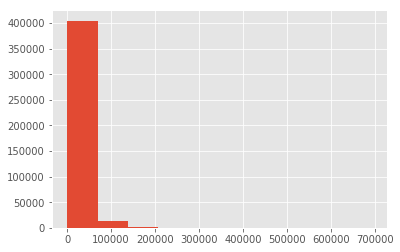

In [11]:
## Ответ:
df.Weekly_Sales.hist( )

Что вы можете сказать об этом распределении? Какие у него есть проблемы? 

In [12]:
# У распределения цен есть проблема - очень длинный хвост. 
# В выборке встречаются точки с довольно большими суммами продаж. 
# Такие наблюдения называются выбросами. 
# С ними нужно бороться, иначе модель подстроится под них. 
# Давайте сгладим распределение цен, прологарифмировав его. 
# Так довольно часто поступают с целевой переменной.

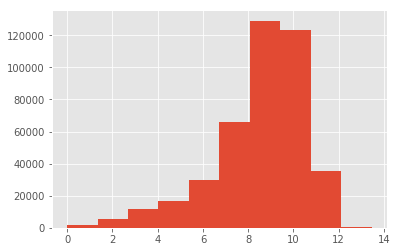

In [13]:
df['ln_Weekly_Sales'] = df['Weekly_Sales'].apply(lambda w: np.log(w + 1))
df.ln_Weekly_Sales.hist( );

__Задание 4__

Мы собираемся прогнозировать продажи, то есть `Weekly_Sales`. Продажи у нас происходят каждый день. То есть у нас в данных есть временная структура. С ней нам предстоит немного поработать. 

Для начала давайте посмотрим, как продажи распределены во времени. 

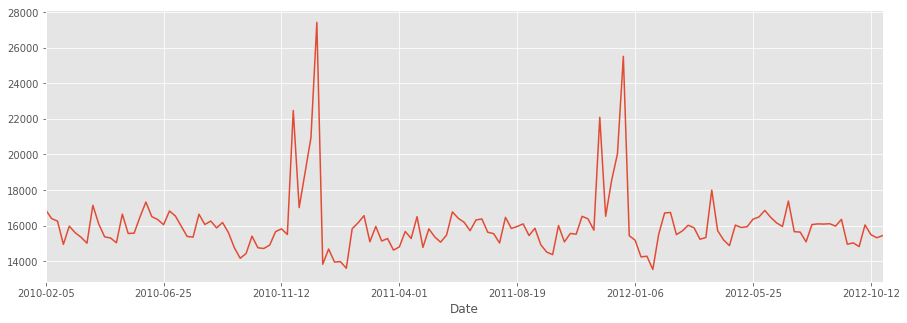

In [14]:
df.groupby('Date')['Weekly_Sales'].mean().plot(figsize=(15,5));

Что мы видим?  В покупках есть какая-то сезонность. Есть даже два пика, выбросы. Они приходятся на праздники: чёрная пятница перед днём благодарения и неделя перед рождеством. Выбросы очень опасны и могут испортить модель.

__Задание 5__ 

Мы хотим прогнозировать будущие продажи. То есть то, что будет завтра по тому, что мы видим вчера. Создадим колонку с целевой переменной. В ней будет записано значение из будущего. Нам нужно сделать это для каждого магазина и отдела. Для этого отсортируем их по датам. 

In [15]:
df.sort_values(['Store', 'Dept', 'Date'], inplace=True) # отсортировали по магазину, отделу, дате

Выясним какая дата последняя.

In [16]:
dates = df.Date.unique()
date_end = dates[-1]
date_end

'2012-10-26'

В нашей табличке теперь все объекты идут друг за другом по времени. Если мы сделаем сдвиг столбца с ценой вверх на единичку, мы получим колонку с будущей ценой. При этом, на позиции `date_end` для каждой колоки мы получим неадекватное значение, соответствующее самой первой цене другого магазина. Придётся выбросить эту дату из рассмотрения. 

In [17]:
df['future_sales'] = df.Weekly_Sales.shift(-1)        # сдвинули цену вверх на один
df['ln_future_sales'] = df.ln_Weekly_Sales.shift(-1)  # и её логарифм
df[['Weekly_Sales', 'future_sales']].head()

,Weekly_Sales,future_sales
0,24924.50,46039.49
73,46039.49,41595.55
145,41595.55,19403.54
218,19403.54,21827.90
290,21827.90,21043.39


Все праздники мы знаем заранее. Их тоже сдвинем вверх на единицу. 

In [18]:
df['IsHoliday'] = df.IsHoliday.shift(-1) # эту колонку мы знаем на будущее по календарю

Для всех остальных переменных мы не знаем их будущих значений до наступления будущего. Например, мы не можем сегодня знать завтрашнюю цену на нефть и использовать её для прогнозирования завтрашних продаж. Все остальные колонки оставляем нетронутыми. 

In [19]:
# выкидываем везде end_date
df = df[df.Date != date_end]
df.head()

,Store,Date,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,ln_Weekly_Sales,future_sales,ln_future_sales
0,1,2010-02-05,1,24924.50,True,A,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,10.123647,46039.49,10.737277
73,1,2010-02-12,1,46039.49,False,A,151315,3.616667,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,10.737277,41595.55,10.635773
145,1,2010-02-19,1,41595.55,False,A,151315,4.405556,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,10.635773,19403.54,9.873262
218,1,2010-02-26,1,19403.54,False,A,151315,8.127778,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,9.873262,21827.90,9.990990
290,1,2010-03-05,1,21827.90,False,A,151315,8.055556,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,9.990990,21043.39,9.954389


# 2. Пропуски в данных 

Посмотрим на пропуски. На картинке ниже жёлтая клетка - это пропуск. Лиловая - это наблюдение. 

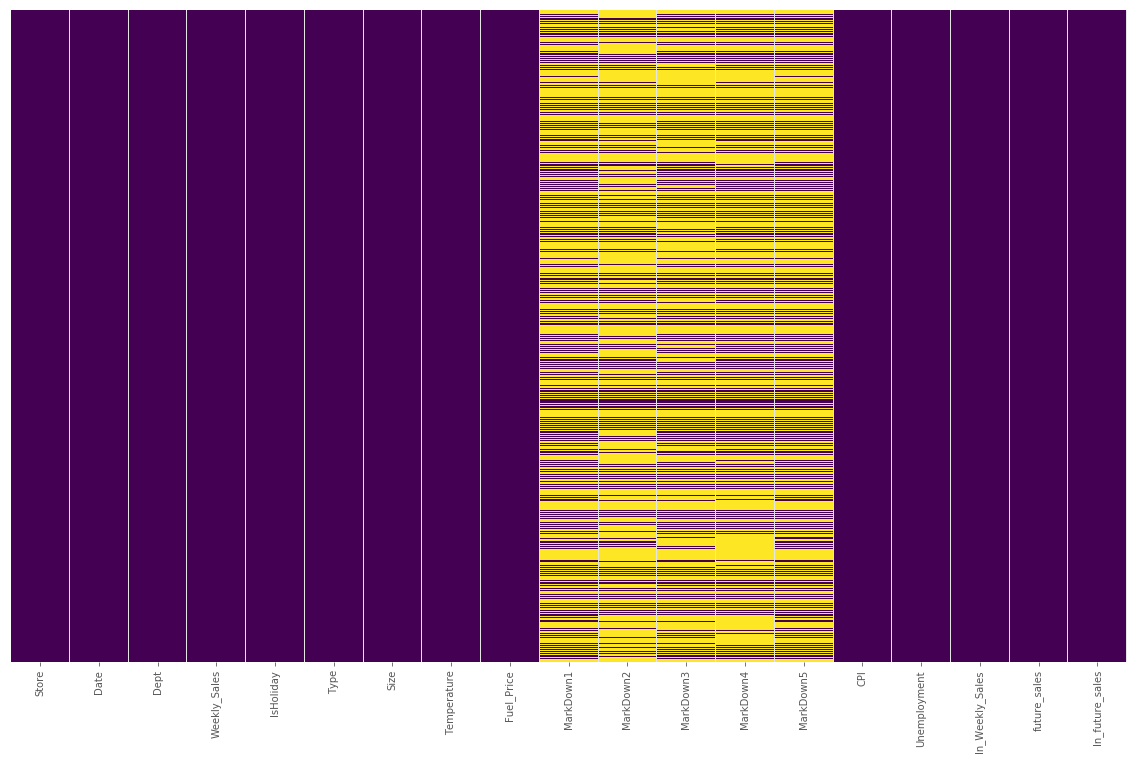

In [20]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Обычно с пропусками себя ведут по-разному. Есть как минимум три стратегии по борьбе с ними: 

* Выбросить все строчки, где допущены пропуски. 
* Выбросить переменные, в которых допущены пропуски. 
* Заполнить пропуски каким-то нейтральным значением, которое не испортит процедуру обучения модели. 

__Задание 6:__ 

Сколько наблюдений у нас останется, если выбросить все строчки с пропусками? Почему это некорректно в случае скидок? Как лучше всего заполнить пустые клетки? 

In [21]:
# Ответ 
print(df.shape)
print(df.dropna().shape)

(417334, 19)
(94896, 19)


In [22]:
# Если выбросить все пропуски, в выборке останутся только магазины, где были скидки 
# Получается, что мы будем учить модель только для скидочных магазинов и результаты 
# окажутся смещёнными
# Лучше заполнить пропуски чем-то нейтральным. В нашем случае нулями, так как, 
# скорее всего, пропуск означает, что в магазине не было скидки. 

In [23]:
df.fillna(0, inplace=True)  # опция inplace применяет изменения к df

# 3. Действительные переменные

В самом начале мы с вами завели список с действительными переменными. Давайте чуть внимательнее посмотрим на них.

__Задание 7:__

Посмотрим на то как распределены наши признаки. Построим для них гистограммы. Что вы видите на них? 

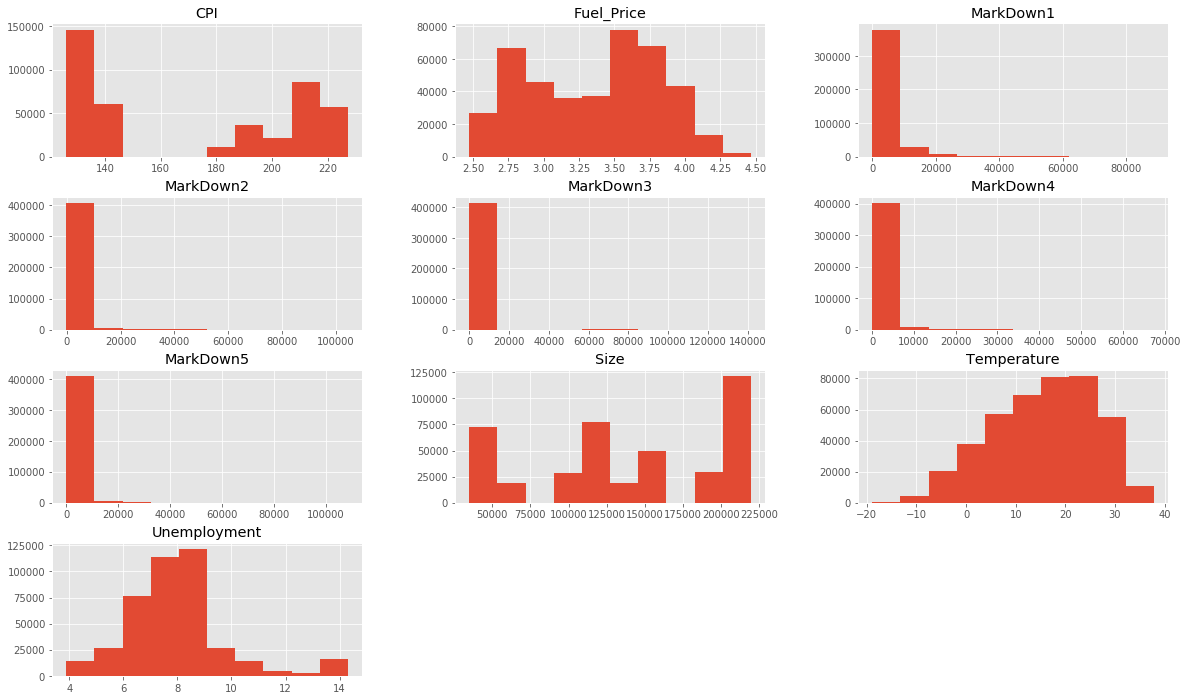

In [24]:
# Ответ:
df[var_real].hist(figsize=(20, 12));

__Задание 8:__

У переменных, которые отвечают за скидки, очень большие хвосты. Давайте сгладим их. Возьмём от всех столбиков логарифмы. 

In [25]:
# Ответ: 
var_mark = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
(df[var_mark] < 0).sum()  # Снова есть отрицательне значения

MarkDown1       0
MarkDown2    1233
MarkDown3     256
MarkDown4       0
MarkDown5       0
dtype: int64

In [26]:
# Эти отрицательные значения оставим в данных со знаком минус
for var in var_mark:
    df['ln_' + var] = df[var].apply(lambda w: np.log(w + 1) if w >= 0 else -1*np.log(-1*w))

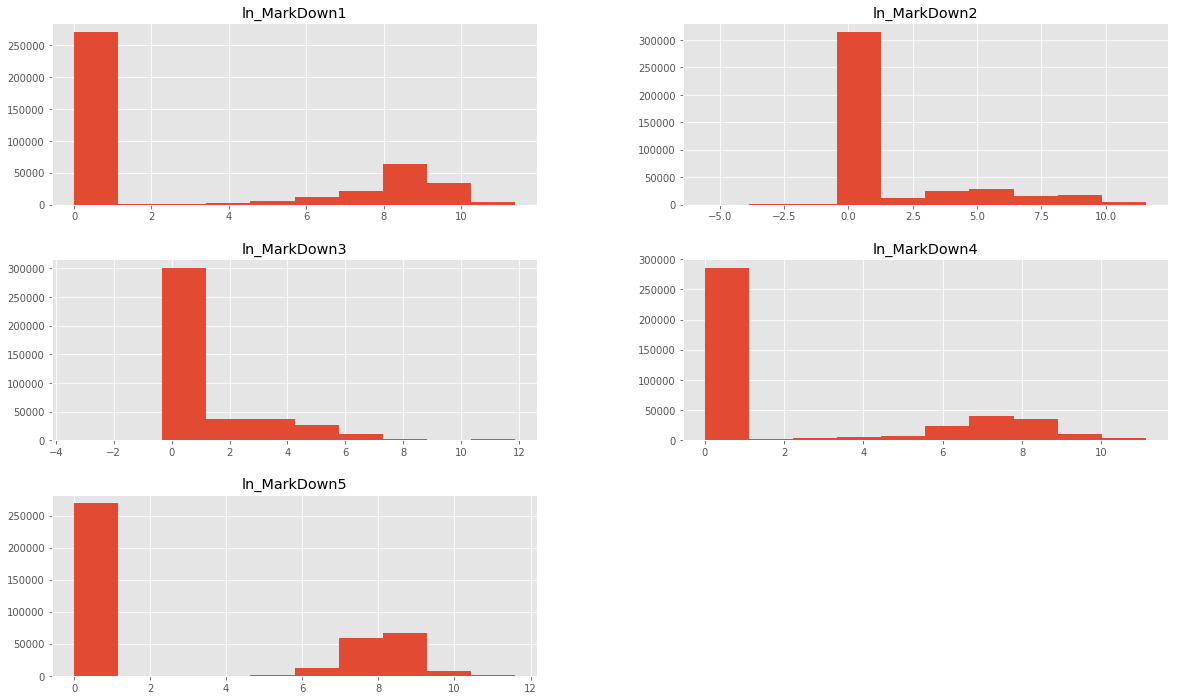

In [27]:
df[['ln_MarkDown1', 'ln_MarkDown2', 'ln_MarkDown3', 'ln_MarkDown4', 'ln_MarkDown5']].hist(figsize=(20, 12));

In [28]:
# Обновим список из действительных переменных 
var_real =  ['CPI', 'Unemployment', 'Temperature', 'Fuel_Price', 'Size',
             'ln_MarkDown1', 'ln_MarkDown2', 'ln_MarkDown3', 'ln_MarkDown4', 'ln_MarkDown5']  

__Задание 9__ 

Давайте теперь посмотрим на матрицу корреляций между действительными переменными и таргетом. Возможно, мы увидим на ней что-то интересное. 

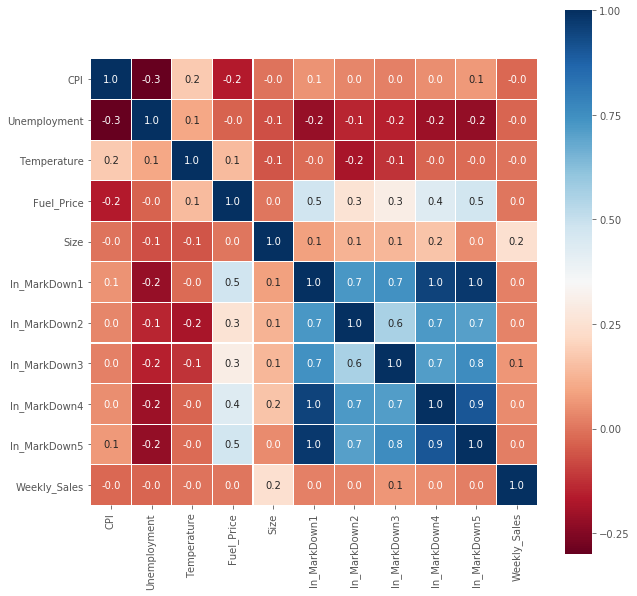

In [29]:
## Ответ: 

plt.figure(figsize=(10,10))
corr = df[var_real + ['Weekly_Sales']].corr()  # посчитали корреляции между регрессорами

# рисуем корреляционную матрицу
sns.heatmap(corr, annot=True, square=True, fmt=".1f", linewidths=0.1, cmap="RdBu");

Видим закономерности: 

* Скидки коррелируют между собой
* Более высокий уровень безработицы означает более низкий ИПЦ (кстати говоря, в экономике называется кривой Филиппса, подробнее об этом можно узнать в бонусных материалах в конце тетрадки) 
* Большие магазины генерируют больше продаж.
* Скидки стимулируют продажи.
* Большая безработица приводит к меньшим продажам. 

__Задание 10:__  

Построим ешё облака рассеивания.

In [30]:
# По полному датасету
# sns.pairplot(df[var_real + ['ln_Weekly_Sales']])

Картинка по полному датасету будет строиться очень дого. В принципе, в этом нет особого смысла. Можно гораздо быстрее построить аналогичную визуализацию по более маленькой подвыборке из датасета. Давайте попробуем сделать это. 

In [31]:
df.shape # изначальные размеры 

(417334, 24)

In [32]:
# если отобрать только 10%
df.sample(frac=0.1, replace=False, random_state=42).shape

(41733, 24)

CPU times: user 42.8 s, sys: 6.85 s, total: 49.6 s
Wall time: 19 s


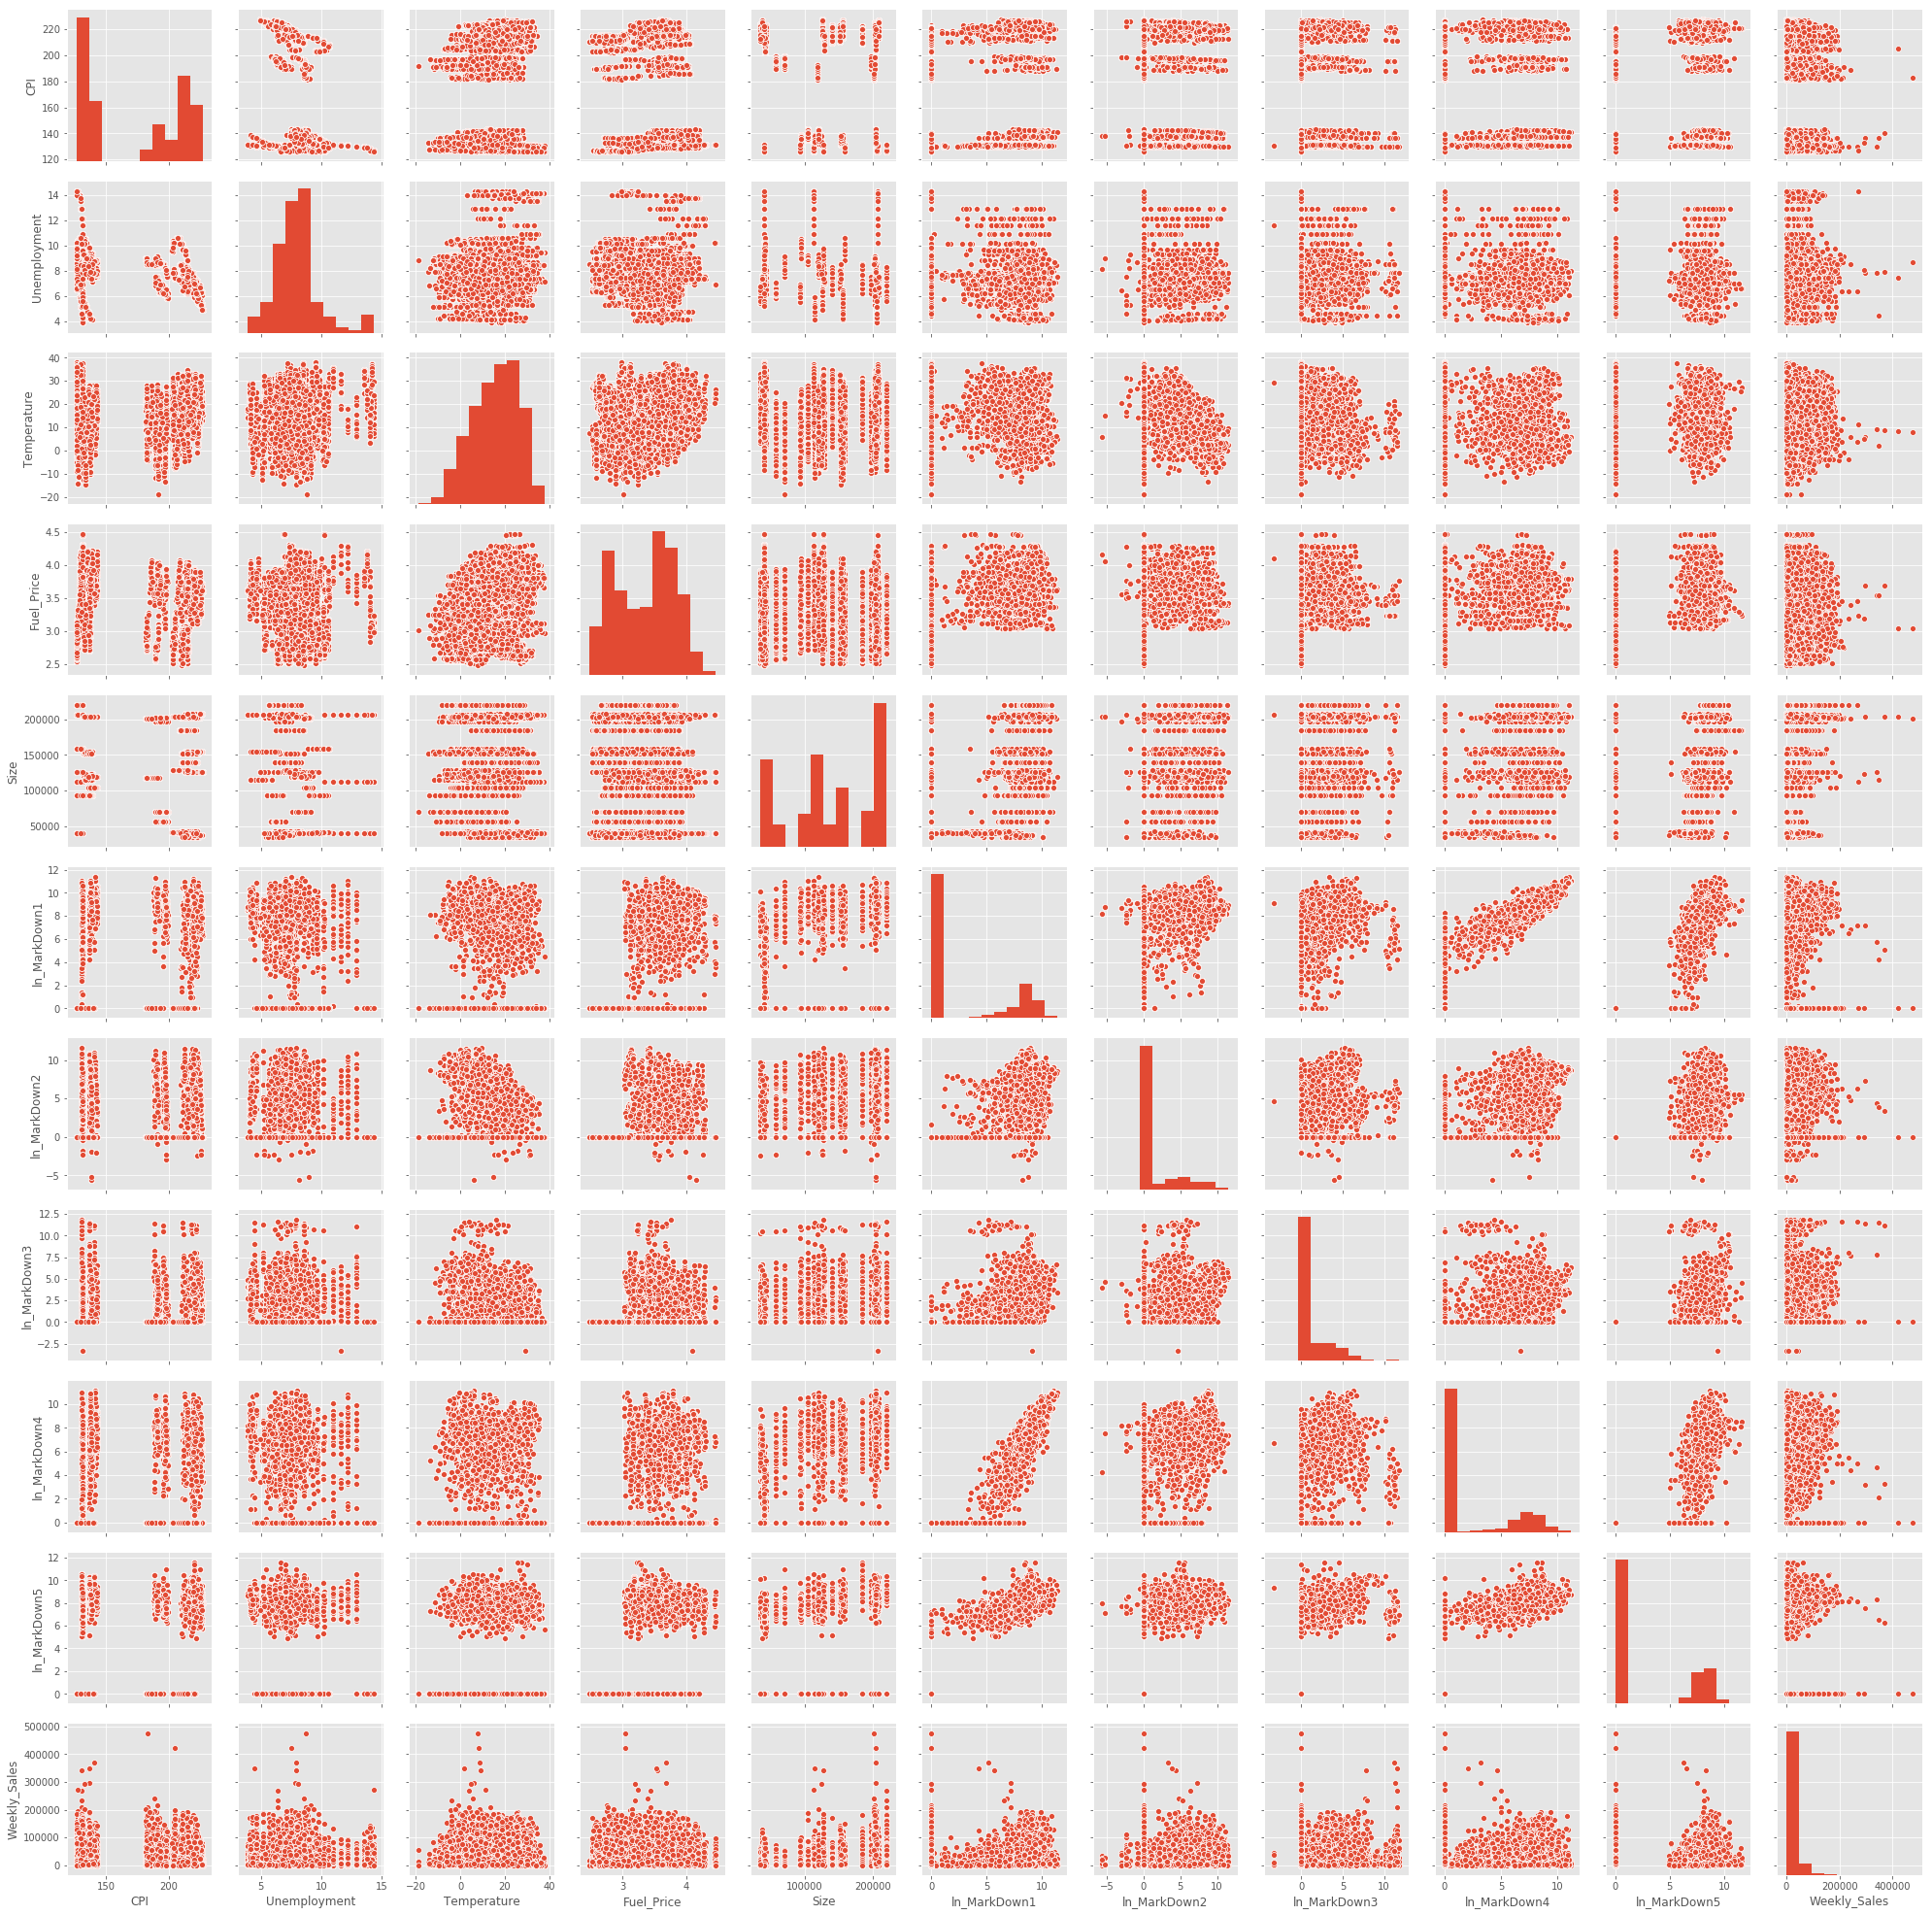

In [33]:
%%time 
# визуализация
df_smpl = df.sample(frac=0.1, replace=False, random_state=1) 
# sns.pairplot(df_smpl[var_real + ['ln_future_sales']]);
sns.pairplot(df_smpl[var_real + ['Weekly_Sales']]);

На получившихся облаках тоже можно найти довольно много интересностей. Например, видно, что соимость топлива зависит от температуры на улице. Нас здесь интересуют, в первую очередь, зависимости между целевой переменной и всеми остальными. Поэтому давайте посмотрим на неё отдельно. 

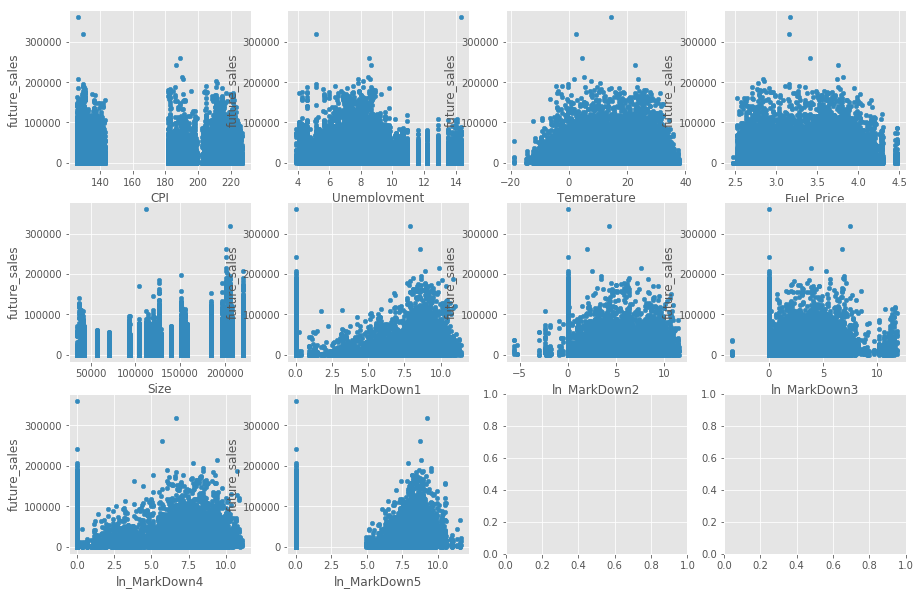

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

for idx, feature in enumerate(var_real):
    df_smpl.plot(feature, 'future_sales', subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Видим, что между  `future_sales` и скидками вылезает какая-то парабалическая зависимость. Хорошо, что мы прологарифмировали эти переменные. Это поможет эту связь уловить. Если бы мы это не сделали, можно было бы закинуть в данные квадраты и учить более сложную модель. 

Но об этом подробнее в домашнем задании. Вухахахахаххах.

# 4. Категориальные переменные 

На действительные переменные поглазели. Теперь бросим свой взор на категориальные переменные. 

In [35]:
df[var_cat].head()

,Type,Store,Dept,IsHoliday
0,A,1,1,True
73,A,1,1,False
145,A,1,1,False
218,A,1,1,False
290,A,1,1,False


__Задание 11__

Все эти переменные - категории. Однако в колонках `Store` и `Dept` стоят числа. Давайте заставим pandas думать, что это текст. 

In [36]:
df[var_cat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417334 entries, 0 to 421502
Data columns (total 4 columns):
Type         417334 non-null object
Store        417334 non-null int64
Dept         417334 non-null int64
IsHoliday    417334 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 13.1+ MB


In [37]:
df[var_cat] = df[var_cat].astype('object')

In [38]:
df[var_cat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417334 entries, 0 to 421502
Data columns (total 4 columns):
Type         417334 non-null object
Store        417334 non-null object
Dept         417334 non-null object
IsHoliday    417334 non-null object
dtypes: object(4)
memory usage: 15.9+ MB


Переменная `IsHoliday` - дамми. Она принимает значение либо да либо нет. Остальные переменные категориальные и принимают значения из довольно большого числа категорий. 

In [39]:
df[var_cat].describe()

,Type,Store,Dept,IsHoliday
count,417334,417334,417334,417334
unique,3,45,81,2
top,A,13,1,False
freq,213495,10387,6390,387848


Алгоритмы умеют учиться на числах. Надо заменить все категории на числа. Вопрос в том, как бы это лучше сделать. Давайте посмотрим на переменную `Type` - тип магазина (A, B или C). Она принимает три значения. Возникает соблазн заменить  все A на 1, B на 2, а C на 3. 

Это неправильный подход. Если так сделать, то некоторые алгоритмы могут подумать, что третий тип самый лучший, а первый самый плохой. Очень большой вопрос, почему мы определили порядок магазинов именно так. Это запутает алгоритм. 

Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много дамми. Вот так:

In [40]:
df['Type'].head()

0      A
73     A
145    A
218    A
290    A
Name: Type, dtype: object

In [41]:
# Переработали в дамми
pd.get_dummies(df['Type'], dummy_na=True, prefix='ohe_').head()

,ohe__A,ohe__B,ohe__C,ohe__nan
0,1,0,0,0
73,1,0,0,0
145,1,0,0,0
218,1,0,0,0
290,1,0,0,0


Если магазин относится к типу $C$, то у него в соответствующем столбце будет стоять единичка, а в остальных нули.

__Приятный бонус:__  Не нужно бороться с пропусками в переменных. Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. Дословно можно перевести как одно горячее кодирование (это шутка такая, если вы так скажите какому-то аналитку, он сначала вас не поймёт, а потом, наверное, поугарает).

В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.

Есть и другие способы обработки категориальных переменных, но мы будем пользоваться этим. Он самый простой. Пропуски мы заполнили, поэтому соотвествующий аргумент приведём в состояние `False`.

In [42]:
# Если пропусков нет, можно без NAN колонки
pd.get_dummies(df['Type'], dummy_na=False).head()

,A,B,C
0,1,0,0
73,1,0,0
145,1,0,0
218,1,0,0
290,1,0,0


Обратите внимание, что в итоговой таблице у нас есть целых три переменные. Одну из них надо выбросить, иначе между столбиками возникает линейная зависимость. То есть один из столбиков дублирует инфомрацию, которая уже есть в других. Из-за этой избыточности мы можем попасть при обучении модели в ловушку. Искуственно мы создаём в данных мультиколинеарность. Это называется дамми-ловушкой. 

In [43]:
# Избавляемся от одного из вариантов, чтобы не попасть в дамми-ловушку
pd.get_dummies(df['Type'], drop_first=True, dummy_na=False).head()

,B,C
0,0,0
73,0,0
145,0,0
218,0,0
290,0,0


__Задание 12:__ 

Движемся дальше. В оставшихся двух переменных есть очень много вариантов категорий. Давайте посмотрим сколько и как они распределены. 

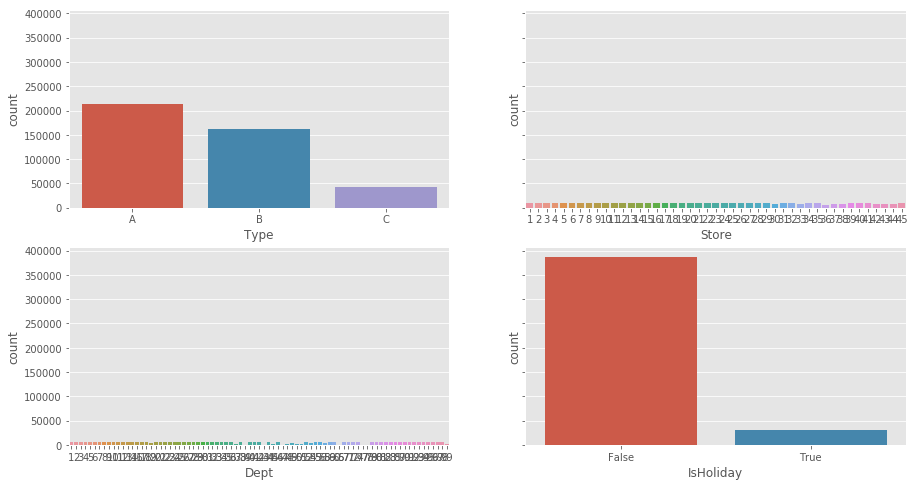

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharey=True)

for i in range(len(var_cat)):
    sns.countplot(x=var_cat[i], data=df, ax=axes[i // 2, i % 2])

In [45]:
# В минимальной категории 6000 наблюдений, для OHE норм
df['Store'].value_counts()[-10:]  

5     8916
9     8772
38    7299
37    7146
30    7091
44    7088
42    6858
43    6682
33    6435
36    6153
Name: Store, dtype: int64

In [46]:
# Тут с OHE для маленьких категорий будут проблемы
df['Dept'].value_counts()[-10:]  

48    1710
50    1549
51    1369
99     850
47     391
78     202
65     142
77     134
39      15
43      12
Name: Dept, dtype: int64

__Задание 13__ 

Для ситуаций, когда есть огромное число категорий и какие-то из них очень мелкие, заводят категорию "другое", куда сваливают всё то, что не попало в большие категории. Давайте ровно это тут и сделаем. 

In [47]:
uniq_category = df['Dept'].unique()  # Уникальные категории
uniq_category

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 58, 59,
       60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92,
       93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65], dtype=object)

In [48]:
# Смотрим какие из них большие
counts = df['Dept'].value_counts()
big_category = counts[counts > 4000].index
big_category

Int64Index([ 1, 10, 38, 21, 67, 14, 13, 79, 81, 46, 82,  8, 90, 91, 92,  7,  4,
            95,  3,  2, 40, 11, 16, 74, 17, 12, 42, 87, 25,  9,  5, 97, 52, 28,
            59, 31, 85, 20, 72,  6, 32, 93, 83, 56, 80, 98, 23, 60, 26, 27, 94,
            55, 22, 44, 24, 33, 41, 34, 29, 71, 35, 30, 36, 18, 96, 54, 49, 58,
            19],
           dtype='int64')

In [49]:
# Вычитаем из множества уникальных множество больших
small_category = list(set(uniq_category) - set(big_category))
small_category

[65, 99, 37, 39, 43, 45, 77, 47, 48, 78, 50, 51]

__Задание 14__

Заменим все маленькие категории из таблицы на категорию $-1$.

In [50]:
df['Dept'] = df['Dept'].apply(lambda w: -1 if w in small_category else w).astype('object')

__Задание 15__ 

Наконец, сделаем для нашей таблички OHE. Он отработает только для тех столбцов, у которых тип object.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417334 entries, 0 to 421502
Data columns (total 24 columns):
Store              417334 non-null object
Date               417334 non-null object
Dept               417334 non-null object
Weekly_Sales       417334 non-null float64
IsHoliday          417334 non-null object
Type               417334 non-null object
Size               417334 non-null int64
Temperature        417334 non-null float64
Fuel_Price         417334 non-null float64
MarkDown1          417334 non-null float64
MarkDown2          417334 non-null float64
MarkDown3          417334 non-null float64
MarkDown4          417334 non-null float64
MarkDown5          417334 non-null float64
CPI                417334 non-null float64
Unemployment       417334 non-null float64
ln_Weekly_Sales    417334 non-null float64
future_sales       417334 non-null float64
ln_future_sales    417334 non-null float64
ln_MarkDown1       417334 non-null float64
ln_MarkDown2       417334 non-null f

Колонка `Date` тоже типа `object`. Давайте временно удалим её.

In [52]:
df.drop('Date', axis=1).shape

(417334, 23)

In [53]:
# кладём всё в новую табличку для преемственности
dff = pd.get_dummies(df.drop('Date', axis=1), drop_first=True, dummy_na=False)
dff.shape

(417334, 135)

In [54]:
dff.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,IsHoliday_True,Type_B,Type_C
0,24924.50,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,0,0,0,0,0,0,0,1,0,0
73,46039.49,151315,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,...,0,0,0,0,0,0,0,0,0,0
145,41595.55,151315,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,...,0,0,0,0,0,0,0,0,0,0
218,19403.54,151315,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,...,0,0,0,0,0,0,0,0,0,0
290,21827.90,151315,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,...,0,0,0,0,0,0,0,0,0,0


# 5. Новые переменные 

Предобработка данных - это очень хорошо. Но кроме этого, нам надо подумать о том, какие новые переменные мы могли бы сварить из наших данных. 

Какие у вас есть идеи по этому поводу? 

* Чёрная пятница и предрождественские праздники (аномальные покупки)
* Переменная, отвечающая за текущий месяц (сезонность)
* Квадраты некоторых переменных 

Что ещё? 

__Задание 16__

Добавим дамми на черные пятницы и на месяца, чтобы уловить сезонность продаж.

In [55]:
df['Date'].head()

0      2010-02-05
73     2010-02-12
145    2010-02-19
218    2010-02-26
290    2010-03-05
Name: Date, dtype: object

Превратим колонку в специалльный временной формат.  Он моможет нам проще делать многие вещи. 

In [56]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head()

0     2010-02-05
73    2010-02-12
145   2010-02-19
218   2010-02-26
290   2010-03-05
Name: Date, dtype: datetime64[ns]

Например, извлекать месяца. 

In [57]:
df['Date'].iloc[0]

Timestamp('2010-02-05 00:00:00')

In [58]:
df['Date'].iloc[0].month

2

Извлечём все месяца и сделаем из них категориальную переменную. 

In [59]:
dff.shape

(417334, 135)

In [60]:
dff['Month'] = df['Date'].apply(lambda w: str(w.month))
dff = pd.get_dummies(dff, drop_first=True, dummy_na=False)

In [61]:
dff.shape

(417334, 146)

In [62]:
dff.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,24924.50,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,0,0,1,0,0,0,0,0,0,0
73,46039.49,151315,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,...,0,0,1,0,0,0,0,0,0,0
145,41595.55,151315,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,...,0,0,1,0,0,0,0,0,0,0
218,19403.54,151315,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,...,0,0,1,0,0,0,0,0,0,0
290,21827.90,151315,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,...,0,0,0,1,0,0,0,0,0,0


Теперь работаем с особыми днями: чёрной пятницей и рождеством. 

In [63]:
# Работаем с особыми днями! 
# Чёрная пятница
dff['Black_Friday'] = np.where((df['Date']=='2010-11-26') | \
                              (df['Date']=='2011-11-25') | \
                              (df['Date']=='2012-11-23'), 1, 0)

# Предрождественские деньки: 
dff['Pre_christmas'] = np.where((df['Date']=='2010-12-23') | \
                               (df['Date']=='2010-12-24') | \
                               (df['Date']=='2011-12-23') | \
                               (df['Date']=='2011-12-24') | \
                               (df['Date']=='2012-12-23') | \
                               (df['Date']=='2012-12-24'), 1, 0)

In [64]:
x = np.array([1,2,3,4,4,5])
np.where(x == 4, 1, 0)

array([0, 0, 0, 1, 1, 0])

__Задание 17__ 

Ещё чего-то ??? 

In [65]:
# Идеи ??? 

# 6. Тестовый период

Отлично! Мы закончили с предобработкой. Давайте разобьём нашу выборку по дате на две части: на тестовую часть и на тренировочную.  На тестовой мы будем проверять наши бизнес-идеи. 

Всё, что было после `2012-04-27` возьмём в тест. Всё, что было до, в обучение. 

In [66]:
df[df['Date'] > '2012-04-27'].shape

(73684, 24)

In [67]:
dff[df['Date'] > '2012-04-27'].shape

(73684, 148)

In [68]:
dff[df['Date'] > '2012-04-27'].to_csv('sales_test_v1.tsv', sep='\t', index=None)

In [69]:
dff[df['Date'] <= '2012-04-27'].to_csv('sales_train_v1.tsv', sep='\t', index=None)

# 7. Метод главных компонент

Эпоха больших данных даёт нам слишком много данных. Часто хочется, чтобы их было немного поменьше, но при этом они содержали бы всю информацию о великом процессе порождения данных. 

Не потерять в знании, но сэкономить! Именно из такого благородного помысла рождается метод главных компонент. Его посыл очень прост: давайте посмотрим на наши данные, найдём в них те направления, в которых происходит самое сильное изменение и оставим только их. 

Например, если наши данные двухмерны, то мы моги бы оставить себе только голубое направление и убрать розовое. 

<img align="center" src="http://108.61.119.12/wp-content/uploads/2014/11/gaussDist-labeled.png" height="500" width="500"> 

При этом, в плане информации мы бы не потеряли особо много. Именно так часто поступают в случае, когда размерность данных очень большая. Находят $d$ Направлений, разброс в которых покрывает $90\%$ дисперсии, а остальное забывают. 

__Ещё раз, ещё раз!__ Если у нас есть выборка из карасей и щук и мы хотим научиться их отличать друг от друга, то мы могли бы оставить только информацию о чешуйках, расположенных вдоль первой, более длинной компоненты. На качество нашего классификатора это бы повлияло слабо, но мы, при этом, избавились бы от лишней размерности, от оценки лишнего коэфициента и могли бы пустить большее число наблюдений на оценку меньшего числа параметров.  

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

Давайте попробуем проделать эту незатейливую операцию.

In [70]:
# Выбрасываем переменные, которые мы будем прогнозировать! 
target = ['Weekly_Sales', 'ln_Weekly_Sales', 'future_sales', 'ln_future_sales']

# Подгрузили метод
from sklearn.decomposition import PCA

# хотим 10 компонент!
model_pca = PCA(n_components= 10)

# обучаем модель
model_pca.fit(dff.drop(target, axis=1))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Смотрим, что вышло. 

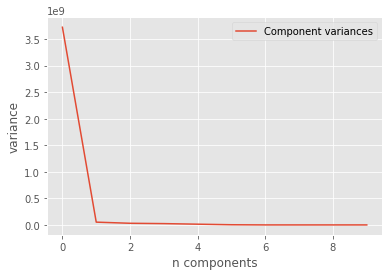

In [71]:
plt.plot(model_pca.explained_variance_, label='Component variances')
plt.xlabel('n components')
plt.ylabel('variance')
plt.legend(loc='upper right');

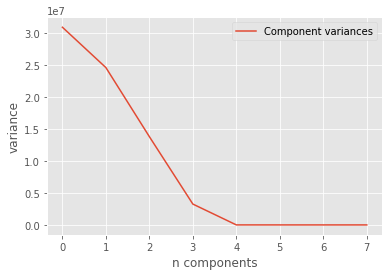

In [72]:
plt.plot(model_pca.explained_variance_[2:], label='Component variances')
plt.xlabel('n components')
plt.ylabel('variance')
plt.legend(loc='upper right');

Можно попробовать взять к себе в датасет несколько главных компонент. Мы это делать не будем, но если бы нам захотелось, то мы бы сделали это так: 

In [73]:
dff_pca =model_pca.transform(dff.drop(target, axis=1))
dff_pca.shape

(417334, 10)

In [74]:
pca_1 = dff_pca[:,0]
pca_2 = dff_pca[:,1]

# 8. Бонус

Помните, когда мы смотрели на корреляционную матрицу, мы увидели, что между безработицей и инфляцией есть отрицательная взаимосвязь: чем больше безработица, тем ниже инфляция. В экономике эта взаимосвязь называется кривой Филиппса. И за ней кроется очень интересная история из целой плеяды ошибок. Давайте попробуем научиться на чужих ошибках чему-нибудь новому. 

В $1958$ году была опубликована статья экономиста Филиппса, в которой он обнаружил достаточно чёткую отрицательную связь между инфляцией и безработицей в Англии за прошедшие $70$ лет. Проверка этой работы на американских данных подтвердила наличие взаимосвязи. Так родилась знаменитая кривая Филиппса. Её стали интерпретировать как некую возможность выбора между высокой инфляцией и высокой безработицей. Нужно сократить безработицу? Давайте напечатаем денег и разгоним инфляцию!

Любому политику безработица кажется более значимой социальной проблемой, нежели инфляция, и он хочет её победить любыми доступными средствами. Самым популярным средством по борьбе с безработицей является агрессивная монетарная политика, которая состоит в расширении денежной массы. Грубо говоря, просто печатают ещё денег. Именно это и было сделано президентом США Ричардом Никсоном в начале $1970$-х гг. в ходе погони за низкой безработицей и высокой инфляцией.

К сожалению, план Никсона удался только наполовину, он добился высокой инфляции, но сбить безработицу не смог. В краткосрочном периоде она действительно упала, но через некоторое время вернулась назад. Кривая Филиппса в этот период времени исчезла из данных. Никой взаимосвязи между безработицей и инфляцией больше не прослеживалось.

В течение $70$-х все Западные страны поэкспериментировали с кривой Филиппса. В конечном итоге, $1980$-е годы были потрачены на обуздание разогнанной инфляции. Победа над инфляцией обошлась довольно дорого. Например, Пол Волкер, возглавлявший в этот период времени ФРС США, взвинтил процентную ставку до $19\%$. Высокие ставки отправили экономику в рецессию. Такая жёсткая принципиальная политика ФРС позволила сбить инфляционные ожидания.

__Какова мораль этой истории?__ Политики увидели в данных закономерность, но начав бороться с безработицей, печатая деньги, немного перепутали причину и следствие. На самом деле никакой чёткой отрицательной зависимости между инфляцией и безработицей в природе не существует. Её наличие в данных является следствием сложного взаимодействия между экономическими агентами. Попытавшись воздействовать на следствие, а не на причину, политики налажали.

Не путайте причину и следствие, когда смотрите в данные и помните, что работа с ними малость сложнее, чем просто открыть питон и оценить пару деревьев.